# Detector Model Evaluation

This notebook includes the below:
- Model evaluation using COCO-Text API
- Model evaluation using Average Precision (AP) score
    - Scripts to calculate AP score
    - Generate training summary with loss and AP scores on train and validation sets
        - Training summary for COCO-Text
        - Training summary for library books - 1st round (128 train images)
        - Training summary for library books - 2nd round (160 train images)
    - Final AP score on library books test set

In order to calculate the AP scores, the prediction result files need to be generated beforehand (refer to the notebook *04_generating-train-val-prediction-files.ipynb*), so that they can be compared against the ground truth annotations.

## Evaluation on COCO-Text using COCO-Text API

### Scripts to Convert Darkflow Output to COCO-Text Results

COCO-Text evaluation API requires specific format on the prediction results.  We need to convert the prediction result files generated by Darkflow to COCO-Text format.

In [267]:
import sys
sys.path.append('../..')

from packages.cocotext import coco_text
from packages.cocotext import coco_evaluation
import json
import glob
import os
from lxml import etree as et
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, PathPatch
import cv2
from ipywidgets import widgets, interact, IntSlider
import numpy as np
import pandas as pd
from tqdm import tqdm

In [261]:
# Load coco-text annotations
ct = coco_text.COCO_Text('../../data/cocotext/COCO_Text.json')

loading annotations into memory...
0:00:01.066493
creating index...
index created!


Since the prediction outputs only indicate image file names, but the COCO-Text result file needs to indicate image IDs, we need to first build a dictionary to map from file name to image ID.

In [262]:
# Generate dictionary mapping from file name to image id.
ct_imgs = ct.loadImgs(ct.val) # use validation set
ct_filename_to_id = {img['file_name'].split('.')[0]: img['id'] for img in ct_imgs}

In [4]:
# Function to generate coco-text result json file
def generate_cocotext_result(src_dir, dst_file):
    prediction_json_paths = glob.glob(os.path.join(src_dir, '*.json'))
    coco_results = []
    for json_path in prediction_json_paths:
        json_file_name = json_path.split('/')[-1]
        file_name = json_file_name.split('.json')[0]  # file name without .json
        coco_id = ct_filename_to_id[file_name]
        
        # Load the json file into a list
        f = open(json_path, 'r')
        bboxes = json.load(f)
        f.close()
        for bbox in bboxes:
            # for each predicted bounding box, convert it to coco-text result format
            x = int(bbox['topleft']['x']) 
            y = int(bbox['topleft']['y']) 
            width = int(bbox['bottomright']['x']) - x
            height = int(bbox['bottomright']['y']) - y
            coco_box=dict()
            coco_box['utf8_string'] = ''
            coco_box['image_id'] = coco_id
            coco_box['bbox'] = [x, y, width, height]
            coco_box['score'] = bbox['confidence']
            coco_box['category_id'] = 91
            coco_results.append(coco_box)
        
    # Dump the coco results into json
    f = open(dst_file, 'w')
    json.dump(coco_results, f, indent=4)
    f.flush()
    f.close()
    print('COCO-Text result file generated.')


In [5]:
# Read from prediction output folder and generate coco-text result file

#prediction_output_dir = '/home/haijie/temp/test/images/val/out'
#cocotext_result_path = '/home/haijie/temp/test/annotations/cocotext-result.json'
prediction_output_dir = '../checkpoints/yolo-cocotext/2018-06-20/val-out'
cocotext_result_path = '../checkpoints/yolo-cocotext/2018-06-20/cocotext-val-result.json'


In [6]:
generate_cocotext_result(prediction_output_dir, cocotext_result_path)

COCO-Text result file generated.


In [7]:
# Use coco-text evaluation API to process the result.
cocotext_results = ct.loadRes(cocotext_result_path)
detections = coco_evaluation.getDetections(ct, cocotext_results, imgIds=ct.val, detection_threshold = 0.5)
endToEnd_results = coco_evaluation.evaluateEndToEnd(ct, cocotext_results, imgIds=ct.val, detection_threshold = 0.5)
coco_evaluation.printDetailedResults(ct, detections, endToEnd_results, 'YOLOv2')


Loading and preparing results...     
DONE (t=0.02s)
YOLOv2

Detection
Recall
legible & machine printed:  4.09
legible & handwritten:  2.42
legible overall:  4.01
illegible & machine printed:  0.06
illegible & handwritten:  0.40
illegible overall:  0.08
total recall:  2.6
Precision
total precision:  31.47
f-score
f-score localization:  4.84

Transcription
accuracy for exact matches:  0.00
accuracy for matches with edit distance<=1:  0.00

End-to-end
recall:  0.00 precision:  0.00
End-to-end f-score:  0

4.09 & 2.42 & 0.06 & 0.40 & 2.6 & 31.47 & 4.84 & 0.00 & 0.00 & 0.00 & 0


## Evaluation Using Average Precision (AP)

### Implementation of AP Calculation
Below is the pipeline for calculating AP given the folders of ground truth annotations (in Pascal VOC XML format) and prediction results (in Darkflow output JSON format).
1. Load ground truth annotations into a list of dictionaries.
2. Load prediction results into a list of dictionaries.
3. For each predicted bounding box, based on a specified IOU threshold (0.5), evaluate whether it is True Positive (TP), False Positive (FP) or repeated match (IG for ignored).
4. Based on the evaluation results, generate the list of precision-recall values with different confidence thresholds.
5. Adjust the precision-recall list with monotonically decreasing precisions.
6. Calculate the area under the adjusted precision-recall curve to obtain the AP score.

Sample format of the intermediate evaluation results:
```json
[{'img_file': 'IMG_20180620_102825', 'obj_id_pred': 2, 'confidence': 1.0, 'result': 'TP', 'obj_id_gt': 23}, {'img_file': 'IMG_20180620_102815', 'obj_id_pred': 7, 'confidence': 1.0, 'result': 'TP', 'obj_id_gt': 9}]
```

In [245]:
# Functions to calculate IOU
def area(rect):
    (l, t, r, b) = rect
    w = r - l + 1
    h = b - t + 1
    return w*h

def intersect_area(rect1, rect2):
    (l1,t1,r1,b1) = rect1;
    (l2,t2,r2,b2) = rect2;
    if (r1<l2 or r2<l1):
        return 0;
    if (b1<t2 or b2<t1):
        return 0;
    l = max(l1, l2)
    r = min(r1, r2)
    t = max(t1, t2)
    b = min(b1, b2)
    return area((l, t, r, b))

def calc_iou(rect1, rect2):
    a1 = area(rect1)
    a2 = area(rect2)
    intersection = intersect_area(rect1, rect2)
    union = a1 + a2 - intersection
    return (intersection / union)

# Load Pascal VOC format annotations into a list
def load_voc_annotations(ann_dir):
    ann_paths = glob.glob(os.path.join(ann_dir, '*.xml'))
    ann_objects = []
    obj_id = 0
    print('Loading Pascal VOC format annotations.')
    sys.stdout.flush()
    for ann_path in tqdm(ann_paths):
        tree = et.parse(ann_path)
        filename = tree.find('filename').text
        img_file = filename.split('.')[0]
        for obj in tree.iter('object'):
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Create annotation entry
            ann_obj = {}
            ann_obj['obj_id'] = obj_id
            ann_obj['img_file'] = img_file
            ann_obj['label'] = obj.find('name').text
            ann_obj['bbox'] = (xmin, ymin, xmax, ymax)
            ann_obj['result'] = 'FN'  # default to False Negative
            ann_objects.append(ann_obj)
            obj_id += 1
    print('Finished loading Pascal VOC format annotations.')
    return ann_objects

# Load Darkflow prediction output annotations into a list
def load_darkflow_annotations(ann_dir):
    ann_paths = glob.glob(os.path.join(ann_dir, '*.json'))
    ann_objects = []
    obj_id = 0
    print('Loading Darkflow format annotations.')
    sys.stdout.flush()
    for ann_path in tqdm(ann_paths):
        filename = ann_path.split('/')[-1]
        img_file = filename.split('.')[0]
        file = open(ann_path, 'r')
        objs = json.load(file)
        file.close()
        #DEBUG
        for obj in objs:
            xmin = obj['topleft']['x']
            ymin = obj['topleft']['y']
            xmax = obj['bottomright']['x']
            ymax = obj['bottomright']['y']
            # Create annotation entry
            ann_obj = {}
            ann_obj['obj_id'] = obj_id
            ann_obj['img_file'] = img_file
            ann_obj['label'] = obj['label']
            ann_obj['confidence'] = obj['confidence']
            ann_obj['bbox'] = (xmin, ymin, xmax, ymax)
            ann_objects.append(ann_obj)
            obj_id += 1
    print('Finished loading Darkflow format annotations.')
    return ann_objects

def get_eval_results(ann_objects_gt, ann_objects_pred, iou_threshold=0.5):
    eval_results = []
    gt_TP = set()
    for pred in ann_objects_pred:  # for each predicted object
        result = 'FP' # default to False Positive
        for gt in ann_objects_gt:  # for each ground truth object
            if gt['img_file'] != pred['img_file']:
                continue;
            iou = calc_iou(pred['bbox'], gt['bbox'])
            if iou >= iou_threshold:
                # prediction matches ground truth
                # check if it is repeated match
                if gt['obj_id'] not in gt_TP:
                    # found a new True Positive.
                    result = 'TP'
                    result_gt = gt
                    gt_TP.add(gt['obj_id'])
                    pred['result'] = 'TP'
                else:
                    # repeated match, ignore
                    result = 'IG'
                    pred['result'] = 'IG'
        
        pred['result'] = result                   
        if result != 'IG':    
            # create a new result entry
            eval_result = {}
            eval_result['img_file'] = pred['img_file']
            eval_result['obj_id_pred'] = pred['obj_id']
            eval_result['confidence'] = pred['confidence']
            eval_result['result'] = result
            if result == 'TP':
                eval_result['obj_id_gt'] = result_gt['obj_id']
            eval_results.append(eval_result)               
    return eval_results

def get_eval_results_from_dirs(ann_dir_gt, ann_dir_pred):
    # Load ground truth annotations
    ann_objects_gt = load_voc_annotations(ann_dir_gt)
    # Load and sort prediction annotations
    ann_objects_pred = load_darkflow_annotations(ann_dir_pred)
    ann_objects_pred.sort(key=lambda obj: obj['confidence'], reverse=True)
    # Evaluation results
    eval_results = get_eval_results(ann_objects_gt, ann_objects_pred)
    eval_tp = [result for result in eval_results if result['result']=='TP']

    print('Total number of ground truth annotations: ', len(ann_objects_gt))
    print('Total number of predictions: ', len(ann_objects_pred))
    print('Total number of evaluation results: ', len(eval_results))
    print('Total number of True Positives: ', len(eval_tp))
    return eval_results, ann_objects_gt, ann_objects_pred 

# Calculate precision and recall on different confidence threshold
def calc_precision_recall(eval_results, n_gt):
    # Get distinct confidence values
    confidence_list = [result['confidence'] for result in eval_results]
    confidence_list = list(set(confidence_list))
    precision_recall_list = []
    for confidence in confidence_list:
        results = [result for result in eval_results if result['confidence'] >= confidence]
        n_pred = len(results)
        n_TP = len([result for result in results if result['result'] == 'TP'])
        precision = 1.0 * n_TP / n_pred
        recall = 1.0 * n_TP / n_gt
        # Create a new entry
        p_r = {'precision': precision, 'recall': recall, 'confidence': confidence}
        precision_recall_list.append(p_r)
    # Sort the list based on recall with descendant order
    precision_recall_list.sort(key=lambda x: x['recall'], reverse=True)
    return precision_recall_list

# Adjust precision-recall map, such that precision is strictly ascending when recall decreases
def adjust_precision_recall(precision_recall_list):
    max_precision = 0
    # 1st pass: make precision ascending
    for pr in precision_recall_list:
        if pr['precision'] < max_precision:
            pr['precision'] = max_precision
        elif pr['precision'] > max_precision:
            max_precision = pr['precision']

    # 2nd pass: remove duplicate recalls
    remove_mask = []
    for i, pr in enumerate(precision_recall_list):
        if i == len(precision_recall_list) - 1:
            # Last item
            remove_mask.append(True)
        elif pr['recall'] == precision_recall_list[i+1]['recall']:
            # duplicate recall, remove
            remove_mask.append(False)
        else:
            remove_mask.append(True)
    precision_recall_list = np.array(precision_recall_list)[remove_mask]
    return list(precision_recall_list)

def calc_AP(precision_recall_list):
    pr_auc = 0
    for i, pr in enumerate(precision_recall_list):
        if i == len(precision_recall_list) - 1:
            # Last item
            pr_auc += pr['recall'] * pr['precision']
        else:
            next_recall = precision_recall_list[i+1]['recall']
            pr_auc += (pr['recall'] - next_recall) * pr['precision']
    return pr_auc

In [174]:
# Functions for visualization
def show_img(img_file_path):
    img = cv2.imread(img_file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,8))
    plt.imshow(img)

def get_rectangle(rect):
    (l, t, r, b) = rect
    w = r - l
    h = b - t
    return Rectangle([l, t], w, h, alpha=0.1)

def show_eval_bbox(img_file, eval_results, ann_objects_gt, ann_objects_pred):
    # Draw bbox based on eval_results
    # TP in pred: green. TP in gt: blue. FP: red. FN: orange
    results = [result for result in eval_results if result['img_file'] == img_file]
    boxes = []
    colors = []
    n_TP = 0
    for result in results:
        ann_object_pred = next((obj for obj in ann_objects_pred if obj['obj_id'] == result['obj_id_pred']))
        ann_object_pred['bbox']
        rect_pred = get_rectangle(ann_object_pred['bbox'])
        if result['result'] == 'TP':
            # for true positive, draw both prediction and ground truth boxes.
            ann_object_gt = next((obj for obj in ann_objects_gt if obj['obj_id'] == result['obj_id_gt']))
            rect_gt = get_rectangle(ann_object_gt['bbox'])
            boxes.append(rect_gt)
            colors.append('blue')
            boxes.append(rect_pred)
            colors.append('green')
            n_TP += 1
        else:
            boxes.append(rect_pred)
            colors.append('red')
    
    collection = PatchCollection(boxes, facecolors='none', edgecolors=colors, linewidths=3)
    ax = plt.gca()
    ax.add_collection(collection)
    print('Number of predictions: ', len(results))
    print('Number of true positives: ', n_TP)
    
def visualize_eval_results_by_img_file(img_file_path, eval_results, ann_objects_gt, ann_objects_pred):
    filename = img_file_path.split('/')[-1]
    img_file = filename.split('.')[0]
    print(filename)
    show_img(img_file_path)
    show_eval_bbox(img_file, eval_results, ann_objects_gt, ann_objects_pred)

def visualize_eval_results_by_index(index):
    visualize_eval_results_by_img_file(img_paths[index], eval_results, ann_objects_gt, ann_objects_pred)
    
# Plot precision-recall curve
def plot_precision_recall(precision_recall_list, title):
    recalls = [pr['recall'] for pr in precision_recall_list]
    precisions = [pr['precision'] for pr in precision_recall_list]
    plt.plot(recalls, precisions)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')


In [181]:
## Calculate evaluation results
# Ground truth annotations
ann_dir_gt = '../../data/librarybooks/processed/annotations/val'
# Prediction annotations
ann_dir_pred = '../checkpoints/tiny-yolo-booklabel/2018-06-21/val-out'
#ann_dir_pred = '../checkpoints/tiny-yolo-booklabel-more/2018-07-02/val-out'
eval_results, ann_objects_gt, ann_objects_pred = get_eval_results_from_dirs(ann_dir_gt, ann_dir_pred)


Total number of ground truth annotations:  86
Total number of predictions:  92
Total number of evaluation results:  91
Total number of True Positives:  79


In [182]:
# Visualize prediction results interactively
img_dir = '../../data/librarybooks/images/val'
img_paths = glob.glob(os.path.join(img_dir, '*.jpg'))
interact(visualize_eval_results_by_index, index=IntSlider(value=0, description='Index', max=len(img_paths)-1, min=0))

interactive(children=(IntSlider(value=0, description='Index', max=31), Output()), _dom_classes=('widget-intera…

<function __main__.visualize_eval_results_by_index(index)>

Bounding box colors:
- Green: True Positive from prediction
- Blue: True Positive from ground truth
- Red: False Positive from prediction

Any non-annotated book label is False Negative that the model fails to detect.

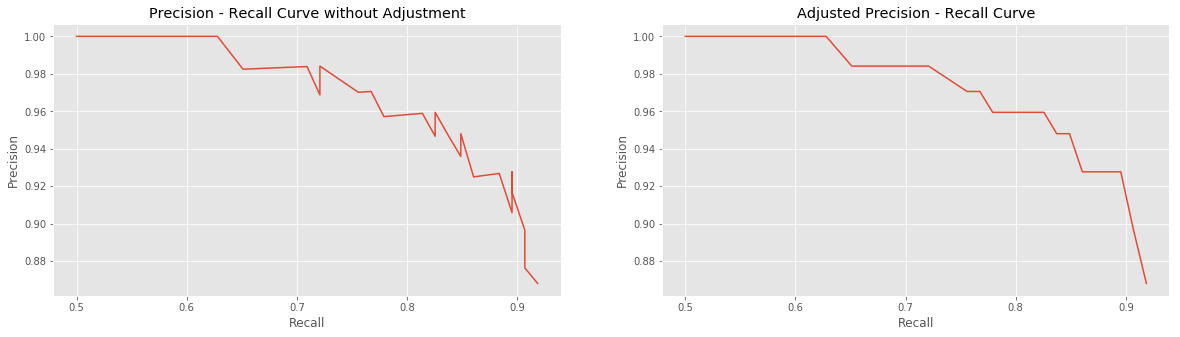

<Figure size 432x288 with 0 Axes>

In [225]:
## Calculate Precision - Recall Curve
plt.style.use('ggplot')
plt.figure(figsize=(20,5))

precision_recall_list = calc_precision_recall(eval_results, len(ann_objects_gt))
plt.subplot(1,2,1)
plot_precision_recall(precision_recall_list, 'Precision - Recall Curve without Adjustment')

precision_recall_list = adjust_precision_recall(precision_recall_list)
plt.subplot(1,2,2)
plot_precision_recall(precision_recall_list, 'Adjusted Precision - Recall Curve')

plt.tight_layout()
plt.show()

In [184]:
# Calculate Average Precision
AP = calc_AP(precision_recall_list)
print('Average Precision: ', AP)

Average Precision:  0.9060964764343873


### Generate Training Summary

The training summary include the list of loss and AP scores on train and val sets.  The loss values come from the Tensorboard summary generated during training using Darkflow.  The AP scores are calculated by comparing the Darkflow prediction results for various checkpoints against the ground truth annotations.

In [246]:
def calc_AP_from_dir(ann_dir_pred, ann_objects_gt):
    ann_objects_pred = load_darkflow_annotations(ann_dir_pred)
    ann_objects_pred.sort(key=lambda obj: obj['confidence'], reverse=True)
    eval_results = get_eval_results(ann_objects_gt, ann_objects_pred)
    precision_recall_list = calc_precision_recall(eval_results, len(ann_objects_gt))
    precision_recall_list = adjust_precision_recall(precision_recall_list)
    return calc_AP(precision_recall_list)
        
def generate_training_summary(train_predictions_dir, ann_objects_gt_train, ann_objects_gt_val):
    dirs = glob.glob(os.path.join(train_predictions_dir, '*'))
    n_dirs = len(dirs)
    # Sort by last subfolder name as integer
    dirs.sort(key=lambda x: int(x.split('/')[-1]))
    train_summary = {'epoch':[], 'train_ap':[], 'val_ap':[]}
    i = 1
    for folder in dirs:
        epoch = folder.split('/')[-1]
        # Calculate AP for training set.
        ann_dir_pred_train = os.path.join(folder, 'train-out')
        train_ap = calc_AP_from_dir(ann_dir_pred_train, ann_objects_gt_train)
        
        # Calculate AP for validation set.
        ann_dir_pred_val = os.path.join(folder, 'val-out')
        val_ap = calc_AP_from_dir(ann_dir_pred_val, ann_objects_gt_val)
        
        # Add to summary
        train_summary['epoch'].append(epoch)
        train_summary['train_ap'].append(train_ap)
        train_summary['val_ap'].append(val_ap)
        
        print('Finished generating training summary for {}/{}.'.format(i, n_dirs))
        i += 1
    return train_summary

def plot_training_score(train_summary):
    plt.plot(train_summary['epoch'], train_summary['train_ap'], label='Train Score(AP)')
    plt.plot(train_summary['epoch'], train_summary['val_ap'], label='Val Score(AP)')
    plt.xlabel('Epoch')
    plt.ylabel('Score(AP)')
    plt.legend()
    plt.xticks(rotation=45)

def plot_training_loss(df):
    plt.plot(df['Epoch'], df['Loss'], label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(rotation=45)

#### Generate Summary of Training on COCO-Text

In [243]:
# Generate training summary of score (Average Precision)
train_predictions_dir = '/home/haijie/machine-learning/myprojects/07-capstone/project-ml/checkpoints/tiny-yolo-cocotext/train-predictions'
ann_dir_gt_val = '/home/haijie/machine-learning/temp/usb-ml/datasets/COCOText/2017/annotations/val'
ann_dir_gt_train = '/home/haijie/machine-learning/temp/usb-ml/datasets/COCOText/2017/annotations/train'

ann_objects_gt_val = load_voc_annotations(ann_dir_gt_val)
ann_objects_gt_train = load_voc_annotations(ann_dir_gt_train)
train_summary_cocotext = generate_training_summary(train_predictions_dir, ann_objects_gt_train, ann_objects_gt_val)


In [257]:
# Load training loss
loss_path = '../checkpoints/tiny-yolo-cocotext/train-summary/yolov2-tiny-voc-cocotext_loss.csv'
batch_size = 32
n_train_img = 43686
df = pd.read_csv(loss_path)
df['Epoch'] = df['Step'] * batch_size / n_train_img + 1

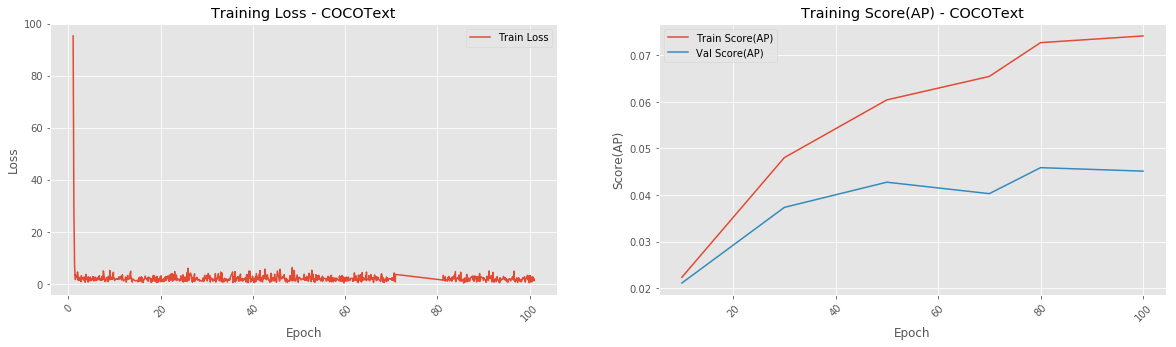

<Figure size 432x288 with 0 Axes>

In [259]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title('Training Loss - COCOText')
plot_training_loss(df)

plt.subplot(1,2,2)
plt.title('Training Score(AP) - COCOText')
plot_training_score(train_summary_cocotext)

plt.show()
plt.tight_layout()

#### Generate Summary of 1st Round of Training on Library Books

In [275]:
# Generate training summary of score (Average Precision)
train_predictions_dir = '../checkpoints/tiny-yolo-booklabel/train-predictions'
ann_dir_gt_val = '../../data/librarybooks/annotations/val'
ann_dir_gt_train = '/home/haijie/machine-learning/temp/usb-ml/datasets/librarybooks/backup/annotations/train'

ann_objects_gt_val = load_voc_annotations(ann_dir_gt_val)
ann_objects_gt_train = load_voc_annotations(ann_dir_gt_train)
train_summary_book1 = generate_training_summary(train_predictions_dir, ann_objects_gt_train, ann_objects_gt_val)


Loading Pascal VOC format annotations.


100%|██████████| 32/32 [00:00<00:00, 2926.94it/s]

Finished loading Pascal VOC format annotations.
Loading Pascal VOC format annotations.



100%|██████████| 128/128 [00:00<00:00, 3292.56it/s]

Finished loading Pascal VOC format annotations.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 23275.42it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 22931.44it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 1/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 27122.91it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 19766.97it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 2/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 32441.29it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 28226.65it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 3/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 33983.47it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 31918.60it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 4/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 32065.40it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 24591.01it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 5/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 33773.96it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 17163.39it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 6/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 34683.82it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 26978.44it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 7/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 37624.99it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 24122.52it/s]


Finished loading Darkflow format annotations.
Finished generating training summary for 8/15.
Loading Darkflow format annotations.


100%|██████████| 128/128 [00:00<00:00, 32782.01it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 20955.15it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 9/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 35913.50it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 16953.10it/s]


Finished loading Darkflow format annotations.
Finished generating training summary for 10/15.
Loading Darkflow format annotations.


100%|██████████| 128/128 [00:00<00:00, 35824.83it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 25395.98it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 11/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 36348.74it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 20323.70it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 12/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 32987.46it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 24297.20it/s]


Finished loading Darkflow format annotations.
Finished generating training summary for 13/15.
Loading Darkflow format annotations.


100%|██████████| 128/128 [00:00<00:00, 37691.02it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 18164.53it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 14/15.
Loading Darkflow format annotations.



100%|██████████| 128/128 [00:00<00:00, 35954.39it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 18800.63it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 15/15.


In [230]:
# Load training loss
loss_path = '../checkpoints/tiny-yolo-booklabel/train-summary/yolov2-tiny-voc-booklabel_loss.csv'
batch_size = 32
n_train_img = 128
df = pd.read_csv(loss_path)
df['Epoch'] = df['Step'] * batch_size / n_train_img

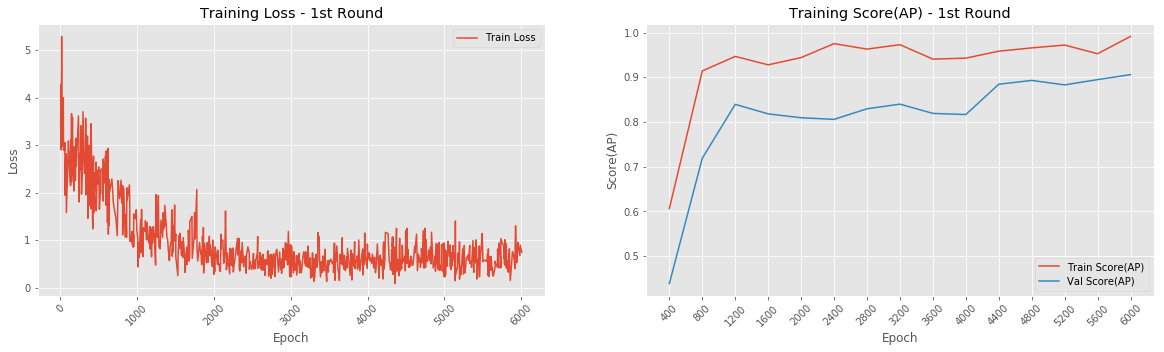

<Figure size 432x288 with 0 Axes>

In [236]:
# Plot training summary
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title('Training Loss - 1st Round')
plot_training_loss(df)

plt.subplot(1,2,2)
plt.title('Training Score(AP) - 1st Round')
plot_training_score(train_summary_book1)

plt.tight_layout()
plt.show()


In [279]:
print('Final validation AP after 1st round: ', round(train_summary_book1['val_ap'][-1], 4))

Final validation AP:  0.9061


#### Generate Summary of 2nd Round of Training on Library Books

In [280]:
train_predictions_dir = '../checkpoints/tiny-yolo-booklabel-more/train-predictions'
ann_dir_gt_val = '../../data/librarybooks/annotations/val'
ann_dir_gt_train = '../../data/librarybooks/annotations/train'

#ann_objects_gt_val = load_voc_annotations(ann_dir_gt_val)
ann_objects_gt_train = load_voc_annotations(ann_dir_gt_train)
train_summary_book2 = generate_training_summary(train_predictions_dir, ann_objects_gt_train, ann_objects_gt_val)


Loading Pascal VOC format annotations.


100%|██████████| 160/160 [00:00<00:00, 10738.79it/s]

Finished loading Pascal VOC format annotations.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6555.01it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 6771.83it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 1/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6859.32it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 6689.15it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 2/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6792.40it/s]

Finished loading Darkflow format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 6544.65it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 3/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6821.46it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6537.64it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 4/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7062.83it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6708.87it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 5/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7037.42it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6599.03it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 6/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7207.64it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6067.43it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 7/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6974.23it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6722.65it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 8/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6982.51it/s]

Finished loading Darkflow format annotations.


Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 5909.81it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 9/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6995.32it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6160.45it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 10/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 6939.19it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6440.70it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 11/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7017.11it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6303.97it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 12/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7002.40it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6597.74it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 13/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7374.11it/s]

Finished loading Darkflow format annotations.


Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 5740.22it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 14/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7055.92it/s]


Finished loading Darkflow format annotations.
Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6709.88it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 15/16.
Loading Darkflow format annotations.



100%|██████████| 160/160 [00:00<00:00, 7030.49it/s]

Finished loading Darkflow format annotations.


Loading Darkflow format annotations.


100%|██████████| 32/32 [00:00<00:00, 6876.26it/s]

Finished loading Darkflow format annotations.
Finished generating training summary for 16/16.


In [238]:
# Load training loss
loss_path = '../checkpoints/tiny-yolo-booklabel-more/train-summary/yolov2-tiny-voc-booklabel-more_loss.csv'
batch_size = 32
n_train_img = 160
df = pd.read_csv(loss_path)
df['Epoch'] = df['Step'] * batch_size / n_train_img

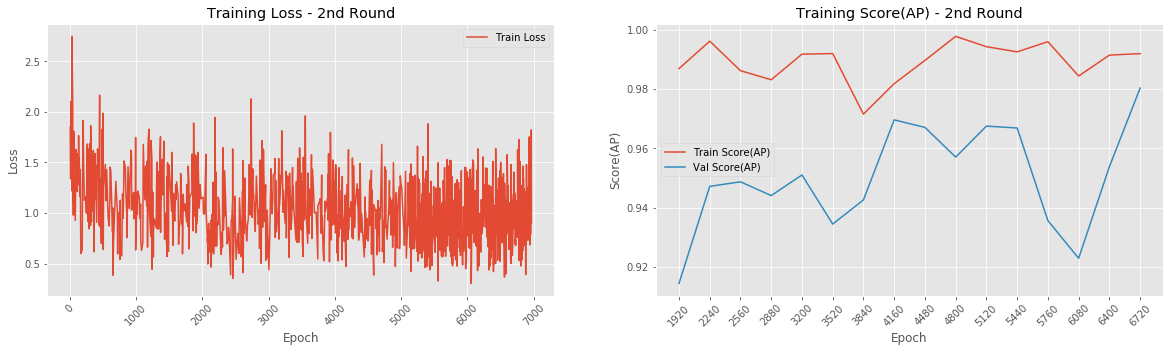

<Figure size 432x288 with 0 Axes>

In [240]:
# Plot training summary
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.title('Training Loss - 2nd Round')
plot_training_loss(df)

plt.subplot(1,2,2)
plt.title('Training Score(AP) - 2nd Round')
plot_training_score(train_summary_book2)

plt.tight_layout()
plt.show()


Total number of ground truth annotations:  86
Total number of predictions:  106
Total number of evaluation results:  106
Total number of True Positives:  85


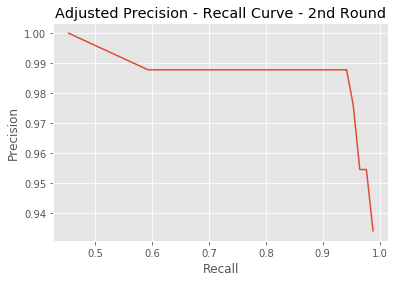

In [242]:
## Calculate precision-recall evaluation results

# Ground truth annotations
ann_dir_gt = '../../data/librarybooks/annotations/val'
# Prediction annotations
ann_dir_pred = '../checkpoints/tiny-yolo-booklabel-more/2018-07-02/val-out'
eval_results, ann_objects_gt, ann_objects_pred = get_eval_results_from_dirs(ann_dir_gt, ann_dir_pred)
precision_recall_list = calc_precision_recall(eval_results, len(ann_objects_gt))
precision_recall_list = adjust_precision_recall(precision_recall_list)

plot_precision_recall(precision_recall_list, 'Adjusted Precision - Recall Curve - 2nd Round')
plt.show()

In [282]:
print('Final validation AP after 2nd round: ', round(train_summary_book2['val_ap'][-1], 4))

Final validation AP after 2nd round:  0.9803


### Evaluation of Final Model on Test Set

In [283]:
## Calculate evaluation results
# Ground truth annotations
ann_dir_gt = '../../data/librarybooks/annotations/test'
# Prediction annotations
ann_dir_pred = '../checkpoints/tiny-yolo-booklabel-more/2018-07-02/test-out'

eval_results, ann_objects_gt, ann_objects_pred = get_eval_results_from_dirs(ann_dir_gt, ann_dir_pred)
precision_recall_list = calc_precision_recall(eval_results, len(ann_objects_gt))
precision_recall_list = adjust_precision_recall(precision_recall_list)

Loading Pascal VOC format annotations.


100%|██████████| 32/32 [00:00<00:00, 2894.62it/s]

Finished loading Pascal VOC format annotations.
Loading Darkflow format annotations.



100%|██████████| 32/32 [00:00<00:00, 6656.63it/s]

Finished loading Darkflow format annotations.
Total number of ground truth annotations:  88
Total number of predictions:  113
Total number of evaluation results:  113
Total number of True Positives:  83


In [284]:
AP = calc_AP(precision_recall_list)
print('Final AP on test set: ', round(AP, 4))

Final AP on test set:  0.9314


# (Unit Tests)

In [256]:
# write train summary to json file
import json
train_summary_dir = '../checkpoints/tiny-yolo-cocotext/train-summary'
os.makedirs(train_summary_dir, exist_ok=True)
json_path = os.path.join(train_summary_dir, 'train-summary-ap.json')
f = open(json_path, 'w')
json.dump(train_summary_cocotext, f, indent=4)
f.flush()
f.close()